Calculate PCs of samples to use in logistic regression model

step 1) Performe **data pre processing** to ensure high quality SNPs are used for calculation of **PCs**

In [1]:
%%bash

# Load required module
module load plink2

# Define base directory
cd "/labs/tassimes/rodrigoguarischi/projects/sea/"

mkdir -p pca_analysis

plink2 \
	--bfile ./data_preparation_to_imputation/hg19_liftover/SEA_Phase2.sex_recoded.hg19_liftover \
	--exclude bed0 ./aux_files/exclude_regions.txt \
	--autosome \
	--geno 0.05 \
	--mind 0.1 \
	--hwe 10e-15 midp \
	--maf 0.01 \
	--indep-pairwise 1000 50 0.05 \
	--out ./pca_analysis/pc_qc

PLINK v2.00a2.3LM 64-bit Intel (24 Jan 2020)   www.cog-genomics.org/plink/2.0/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ./pca_analysis/pc_qc.log.
Options in effect:
  --autosome
  --bfile ./data_preparation_to_imputation/hg19_liftover/SEA_Phase2.sex_recoded.hg19_liftover
  --exclude bed0 ./aux_files/exclude_regions.txt
  --geno 0.05
  --hwe 10e-15 midp
  --indep-pairwise 1000 50 0.05
  --maf 0.01
  --mind 0.1
  --out ./pca_analysis/pc_qc

Start time: Tue May 10 19:09:54 2022
515883 MiB RAM detected; reserving 257941 MiB for main workspace.
Allocated 14523 MiB successfully, after larger attempt(s) failed.
Using up to 64 threads (change this with --threads).
1068 samples (220 females, 848 males; 1068 founders) loaded from
./data_preparation_to_imputation/hg19_liftover/SEA_Phase2.sex_recoded.hg19_liftover.fam.
103083 out of 106248 variants loaded from
./data_preparation_to_imputation/hg19_liftover/SEA_Phase2.sex_recoded.hg19_liftover.bim.
N

Use plink2 to calculate the 20 PCs for the samples

In [2]:
%%bash

# Define base directory
cd "/labs/tassimes/rodrigoguarischi/projects/sea/"

# Load required module
module load plink2

# Create a file to identify subjects as black or white (required by plink)
white_subjects_file='./pca_analysis/subject_ids_whites.txt'
echo "#FID IID" > ${white_subjects_file}
perl -pe "s/_/\t/g" ./data_preparation_to_imputation/subject_ids_whites.txt >> ${white_subjects_file}

black_subjects_file='./pca_analysis/subject_ids_blacks.txt'
echo "#FID IID" > ${black_subjects_file}
perl -pe "s/_/\t/g" ./data_preparation_to_imputation/subject_ids_blacks.txt >> ${black_subjects_file}

# Run plink2 PCA for all subjects in the cohort
plink2 \
	--bfile ./data_preparation_to_imputation/hg19_liftover/SEA_Phase2.sex_recoded.hg19_liftover \
	--extract ./pca_analysis/pc_qc.prune.in \
    --pca 20 \
	--out ./pca_analysis/pca_all

# Run plink2 PCA for white subjects
plink2 \
	--bfile ./data_preparation_to_imputation/hg19_liftover/SEA_Phase2.sex_recoded.hg19_liftover \
    --keep ${white_subjects_file} \
	--extract ./pca_analysis/pc_qc.prune.in \
    --pca 20 \
	--out ./pca_analysis/pca_whites
 
 # Run plink2 PCA for black subjects
plink2 \
	--bfile ./data_preparation_to_imputation/hg19_liftover/SEA_Phase2.sex_recoded.hg19_liftover \
    --keep ${black_subjects_file} \
	--extract ./pca_analysis/pc_qc.prune.in \
    --pca 20 \
	--out ./pca_analysis/pca_blacks

PLINK v2.00a2.3LM 64-bit Intel (24 Jan 2020)   www.cog-genomics.org/plink/2.0/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ./pca_analysis/pca_all.log.
Options in effect:
  --bfile ./data_preparation_to_imputation/hg19_liftover/SEA_Phase2.sex_recoded.hg19_liftover
  --extract ./pca_analysis/pc_qc.prune.in
  --out ./pca_analysis/pca_all
  --pca 20

Start time: Tue May 10 19:09:57 2022
515883 MiB RAM detected; reserving 257941 MiB for main workspace.
Allocated 14523 MiB successfully, after larger attempt(s) failed.
Using up to 64 threads (change this with --threads).
1068 samples (220 females, 848 males; 1068 founders) loaded from
./data_preparation_to_imputation/hg19_liftover/SEA_Phase2.sex_recoded.hg19_liftover.fam.
106248 variants loaded from
./data_preparation_to_imputation/hg19_liftover/SEA_Phase2.sex_recoded.hg19_liftover.bim.
Note: No phenotype data present.
--extract: 20174 variants remaining.
Calculating allele frequencies... 59done.


In [3]:
# Import all necessary libraries

import pandas as pd
import os

os.chdir("/labs/tassimes/rodrigoguarischi/projects/sea/")

# Read phenotypes and recode sex and race attributes
sea_phenotypes = pd.read_table(
    "data_preparation_to_imputation/86679/NHLBI/SEA_Herrington/phs000349v1/p1/phenotype/phs000349.v1.pht002191.v1.p1.c1.SEA_Phase2_Subject_Phenotypes.GRU.txt",
    index_col="seaid",
    comment="#")

# Recode Sex and Race
sea_phenotypes = sea_phenotypes.replace( {
    "sex": { 1:"male", 2:"female" },
    "race": { 1:"white", 2:"black" }
    } )

# Read phenotypes and recode sex and race attributes
pca_analysis = pd.read_table(
    "./pca_analysis/pca_all.eigenvec",
    index_col="IID")

# Consolidate data into a dataframe and print first lines
sea_dataset_full = pd.concat( [sea_phenotypes, pca_analysis], axis=1 )

# Print counts by race and sex and first lines from dataframe 
print( sea_dataset_full.groupby(["race","sex"])["sex"].count() )
sea_dataset_full

race   sex   
black  female     92
       male      412
white  female    128
       male      436
Name: sex, dtype: int64


,dbGaP SubjID,sex,race,age,agex2,bmi,tf,tr,af,ar,...,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
pd10016,445969,female,white,29,841,19.9,6.7,0.0,10.7,0.0,...,0.008669,-0.000562,-0.021052,-0.041693,0.035019,0.000110,0.022164,0.017952,-0.019470,-0.003843
pd10018,445970,male,white,30,900,28.3,27.3,0.0,22.0,0.0,...,-0.003186,-0.006778,-0.008204,0.015600,-0.013228,-0.003694,-0.013855,-0.022994,-0.005164,-0.018541
pd10023,445971,male,white,27,729,21.7,27.3,0.0,55.0,0.0,...,0.012559,0.012241,0.007553,0.005361,-0.034921,0.002082,-0.028228,-0.008999,0.017288,0.019418
pd10028,445972,male,black,31,961,29,16.0,0.0,36.8,14.8,...,0.002174,-0.007407,-0.014465,-0.006264,0.026485,0.011153,-0.012070,-0.045577,-0.021058,0.047323
pd10031,445973,male,white,28,784,21.5,20.0,0.0,16.7,0.0,...,0.031616,-0.011976,-0.018912,0.052658,0.004220,0.010797,-0.002492,0.008964,0.025533,-0.032772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pd12871,447032,male,white,25,625,26,15.0,0.0,9.0,0.0,...,0.009172,0.034348,-0.015335,0.001257,0.004651,-0.006209,-0.016752,0.007346,0.043201,0.004141
pd12872,447033,male,black,26,676,18.9,53.3,0.0,55.0,0.0,...,0.099070,0.076673,-0.074187,0.010038,-0.032271,0.049153,0.044063,-0.000847,0.006425,0.002151
pd12873,447034,male,black,17,289,21.9,18.0,0.0,19.0,0.0,...,-0.039133,-0.005075,-0.021201,0.047834,-0.022270,0.010321,-0.015463,0.023275,-0.011829,0.001754
pd12875,447035,male,black,23,529,22.7,17.7,0.0,32.3,0.0,...,0.006738,0.017124,-0.007606,0.013739,0.070409,-0.003103,-0.021578,-0.018626,0.065054,0.058231


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

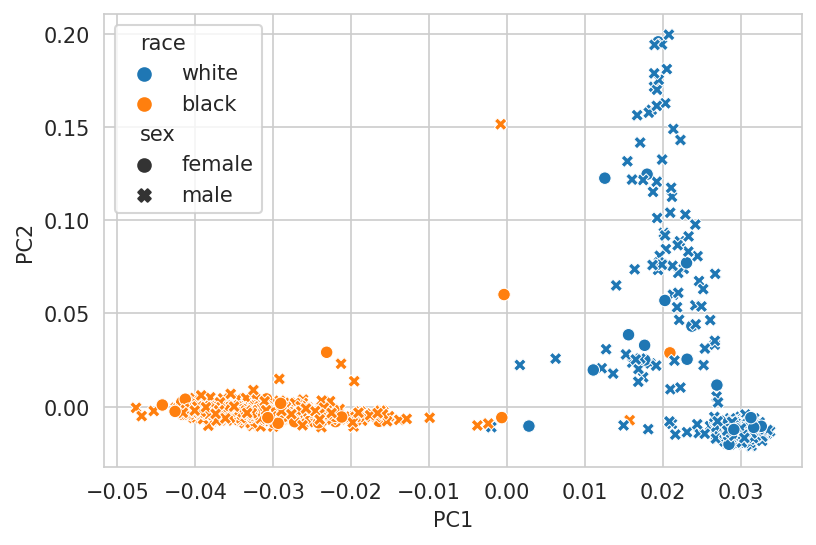

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi']= 150

sns.set_style('whitegrid')

sns.scatterplot(
    x = "PC1",
    y = "PC2",
    data = sea_dataset_full,
    hue= "race",
    style= "sex"
    )
